## Tutorial 19 - Interpolation & Integration

In [341]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy import integrate

### Numerical integration

Recall that in Homework 4, we used a numerical integration method to calculate the number of detections we expect over 10 seconds given the Detector Response Function we were given. This was also described in the slides for Lecture 12. 

The method that we used at the time was actually a midpoint rule integration. 

\begin{align*}
    N_\mathrm{det} &= T_\mathrm{obs} \int^{E_1}_{E_0} f_E(E)\ A_\mathrm{eff}(E)\ dE \qquad &&\text{integral form}\\
    N_\mathrm{det} &= T_\mathrm{obs} \sum_i f_E(E_i^{\ \mathrm{mid}})\ A_\mathrm{eff}(E_i^{\ \mathrm{mid}})\ \Delta E \qquad &&\text{sum approximation}\\
\end{align*}
where  $\Delta E = E_{i+1} - E_i$  and  $E_i^{\ \mathrm{mid}} = (E_i + E_{i+1})/2$.

* Download the fits file that we used in Homework 4 again that contains the detector response matrix (Can be found on Canvas [here](https://psu.instructure.com/courses/2367528/files/174931328?wrap=1)).

* Get the HDU with the DRM in it. Remember this will be a table with a column named MATRIX in it. This column is the DRM.
* The other columns in this table are named ENERG_LO and ENERG_HI, these are the low and high photon energies that each row in the DRM corresponds to. 
    - Find the midpoint between ENERG_LO and ENERG_HI and set that array equal to a variable named `Photon_Energies`

In [342]:
# Open the FITS file
f = fits.open('Fermi_GBM_DRM.fits')
#f.info()
num_hdus = len(f)

# Loop through all HDUs to check for the 'MATRIX' column
for i in range(num_hdus):
    hdu = f[i]
    if hdu.data is not None:  # Ensure the HDU has data
        data_cols = hdu.data.names  # Get the column names
        if 'MATRIX' in data_cols:
            drm = hdu.data['MATRIX']  # Access the 'MATRIX' column in the data
            Photon_Energies = 0.5 * (hdu.data['ENERG_HI'] + hdu.data['ENERG_LO'])  # Calculate photon energies
            print("The correct HDU is", i)
            break  # Exit the loop once the correct HDU is found

The correct HDU is 1


The function below should be similar to the one you wrote in Homework 4. It calculates the differential photon flux for a power-law spectrum at an array of photon energies. 

The inputs are:
* an array of photon energies
* the spectral index, $\alpha$
* the normalization factor, $C$

In [343]:
def f_E(E, alpha, C):
    '''
    Compute the differential photon flux for a power-law spectrum

    Parameters:
    -----------
    E: array
        Photon energies in keV
    alpha: float
        Spectral index 
    C: float
        Normalization factor in photons / cm^2 / s / keV

    Returns:
    -----------
    array 
        Differential photon flux 

    '''

    E0 = 100                        # pivot energy = 100 keV
    f_E = C * (E/E0) ** alpha       # calculate f_E

    return f_E

* Find the effective area from the DRM as a function of photon energy
    - Hint: We did this in Tutorial 10 as well as Homework 4
* Using your function calculate the differential photon fluxes at the energies in Photon_Energies for $\alpha = -2$, and $C = 5 \times 10^{-4}$ photons / cm $^2$ / s / keV

In [344]:
print(drm.shape)

Aeff = np.sum(drm, axis=1)  # Effective area for each energy channel
fluxes = f_E(Photon_Energies, -2, 5e-4)

(140, 8)


Use the trapezoid rule + simpsons rule functions in `scipy.integrate` to find the # of detections in a 10 second exposure.
* `integrate.trapezoid(y, x)`
* `integrate.simpson(y, x)`

In [345]:
#For both
#N_det = time * integral of fluxes * Aeff d (Enegry)

#Using summation
N_det_sum = 0
for i in range(len(Photon_Energies)-1):
    N_det_sum += fluxes[i] * Aeff[i] * (Photon_Energies[i+1] - Photon_Energies[i])  # Integrate over the photon energies
print("Number of detections using summation:", N_det_sum)


# Trapezoid rule
N_det_trap = integrate.trapezoid(fluxes*Aeff, x=Photon_Energies, dx=1e-3)  # Integrate over the photon energies
print("Number of detections using trapezoid rule:", N_det_trap)

Number of detections using summation: 42.641197
Number of detections using trapezoid rule: 41.282864


In [346]:
# Simpsons rule
N_det_simp = integrate.simpson(fluxes*Aeff, x=Photon_Energies)  # Integrate using Simpson's rule
print("Number of detections using Simpson's rule:", N_det_simp)

Number of detections using Simpson's rule: 41.254625463236984


### Interpolation

For the other function in `scipy.intergrate` (i.e. `quad`), we need the values we are integrating to have a "functional" form (similar to `minimize`). This is an area where we can use our interpolation functions in `scipy.interpolate`

In [347]:
from scipy import interpolate

Plot the "integrand" of the integral we are computing $f_E(E)\ A_\mathrm{eff}(E)$. Use circles for your markers.

Text(0.5, 1.0, 'Effective Area * Flux vs Photon Energy')

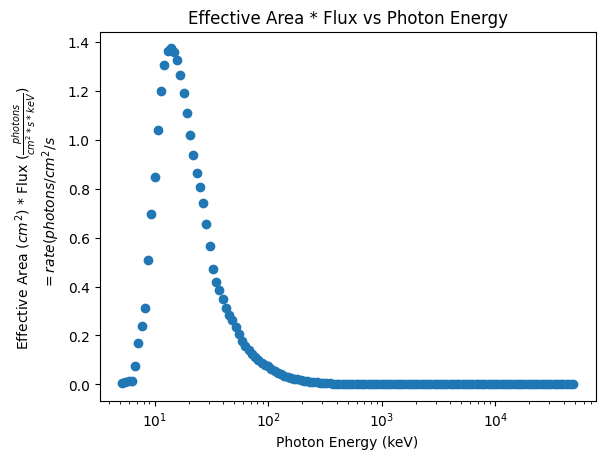

In [348]:
plt.plot(Photon_Energies, fluxes*Aeff , 'o')
plt.semilogx()                                  # set the x-axis to be log-scaled

# add labels to your plot
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Effective Area ($cm^2$) * Flux ($\\frac{photons}{cm^2 * s * keV}$) \n  $ = rate ( photons / cm^2 / s$')
plt.title('Effective Area * Flux vs Photon Energy')

We can see here that our "x" values are not evenly spaced in linear space. Rather they are evenly spaced on a logarithmic scale. Because our interpolate functions want evenly spaced values, we can define a new variable `log_Photon_Energies` which we'll use for this part in place of `Photon_Energies`

Text(0.5, 1.0, 'Effective Area * Flux vs Photon Energy')

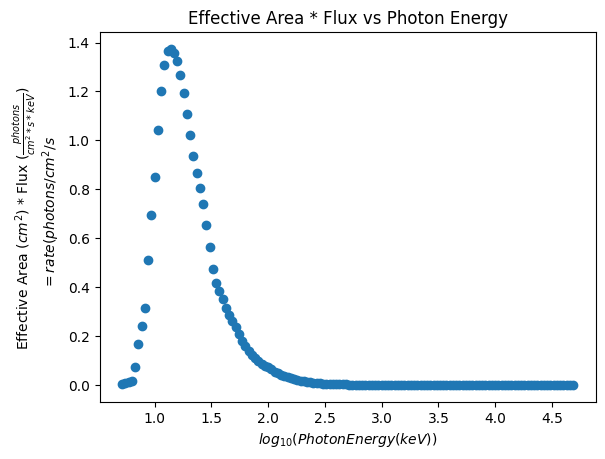

In [349]:
log_Photon_Energies = np.log10(Photon_Energies)
plt.plot(log_Photon_Energies, fluxes*Aeff, 'o')

# add labels to your plot
plt.xlabel('$ log_{10} (Photon Energy (keV))$')
plt.ylabel('Effective Area ($cm^2$) * Flux ($\\frac{photons}{cm^2 * s * keV}$) \n  $ = rate ( photons / cm^2 / s$')
plt.title('Effective Area * Flux vs Photon Energy')

First, use `np.interp1d` to get a linear interpolation of the points.

**🔴 This function does not exist, the interp1d function is in scipy.integrate not numpy 🔴**

Text(0.5, 1.0, ' Linear Interpolation of Effective Area * Flux vs Photon Energy')

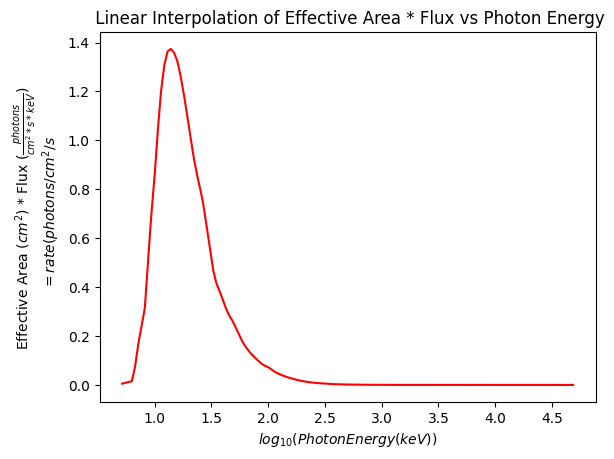

In [350]:
# Linear interpolation

xnew = np.linspace(np.min(log_Photon_Energies), np.max(log_Photon_Energies), num = 10 * len(log_Photon_Energies))  # New x values for interpolation

#incorrectly said to use np.interp1d when numpy does not have this function
# use scipy.interpolate.interp1d instead
linear_f = interpolate.interp1d(log_Photon_Energies, fluxes*Aeff, kind='linear')
y_linear = linear_f(xnew)
plt.plot(xnew, y_linear, 'r-')
plt.xlabel('$ log_{10} (Photon Energy (keV))$')
plt.ylabel('Effective Area ($cm^2$) * Flux ($\\frac{photons}{cm^2 * s * keV}$) \n  $ = rate ( photons / cm^2 / s$')
plt.title(' Linear Interpolation of Effective Area * Flux vs Photon Energy')

* Use `interpolate.interp1d` to get a piece-wise interpolation of the points
    - Note: reminder to use the keyword `kind="nearest"` for this
* Use `interpolate.CubicSpline` to get a Cubic Spline

**Remember** these functions each return a **function** that takes an array of $x$ values and returns the "interpolated" $y$-values

Text(0.5, 1.0, ' Piecewise Interpolation of Effective Area * Flux vs Photon Energy')

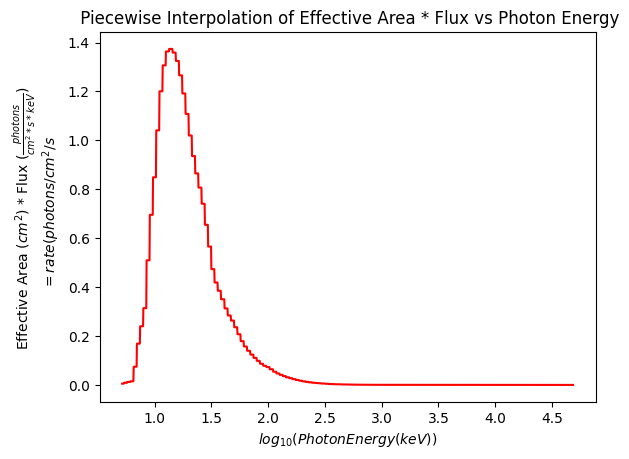

In [351]:
# Piecewise
piecewise_f = interpolate.interp1d(log_Photon_Energies, fluxes*Aeff, kind='nearest')
y_piecewise = piecewise_f(xnew)
plt.plot(xnew, y_piecewise, 'r-')

plt.xlabel('$ log_{10} (Photon Energy (keV))$')
plt.ylabel('Effective Area ($cm^2$) * Flux ($\\frac{photons}{cm^2 * s * keV}$) \n  $ = rate ( photons / cm^2 / s$')
plt.title(' Piecewise Interpolation of Effective Area * Flux vs Photon Energy')

Text(0.5, 1.0, ' Cubic Interpolation of Effective Area * Flux vs Photon Energy')

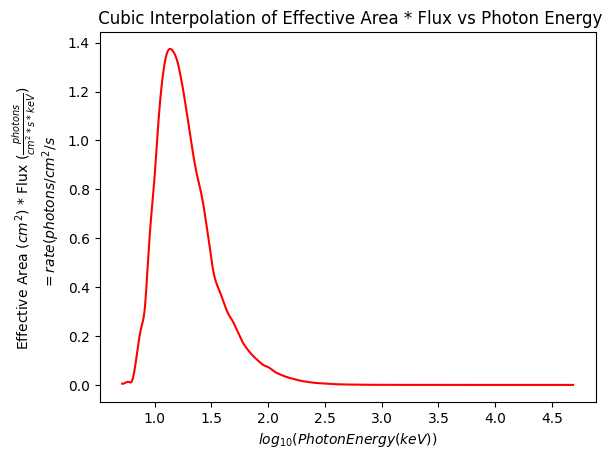

In [352]:
# Cubic
cubic_f = interpolate.interp1d(log_Photon_Energies, fluxes*Aeff, kind='cubic')
y_cubic = cubic_f(xnew)
plt.plot(xnew, y_cubic, 'r-')

plt.xlabel('$ log_{10} (Photon Energy (keV))$')
plt.ylabel('Effective Area ($cm^2$) * Flux ($\\frac{photons}{cm^2 * s * keV}$) \n  $ = rate ( photons / cm^2 / s$')
plt.title(' Cubic Interpolation of Effective Area * Flux vs Photon Energy')

Plot each of these functions between `np.min(log_Photon_Energies)` and `np.max(log_Photon_Energies)`

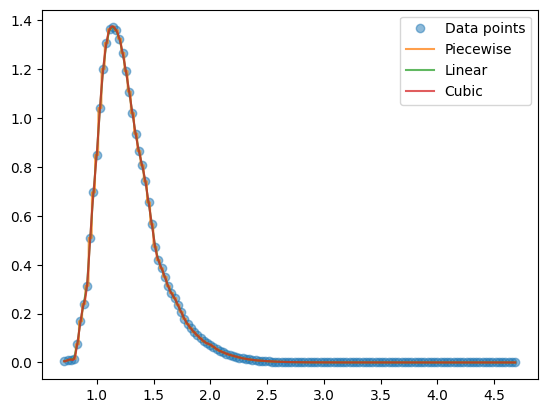

In [353]:
plt.plot(log_Photon_Energies, fluxes*Aeff, 'o', alpha=0.5, label='Data points')
plt.plot(xnew, y_piecewise, label='Piecewise', alpha=0.75)
plt.plot(xnew, y_linear, label='Linear',alpha=0.75)
plt.plot(xnew, y_cubic, label='Cubic', alpha=0.75)
plt.legend()

(0.75, 1.4)

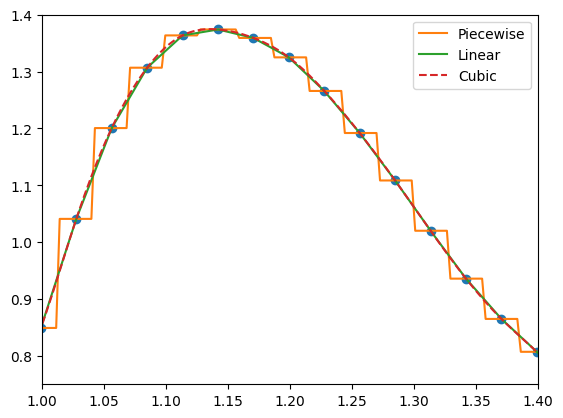

In [354]:
# If we zoom in using plt.xlim we can see the difference between the three methods

plt.plot(log_Photon_Energies, fluxes*Aeff, 'o')
plt.plot(xnew, y_piecewise, label='Piecewise')
plt.plot(xnew, y_linear, label='Linear')
plt.plot(xnew, y_cubic, '--', label='Cubic')
plt.legend()
plt.xlim(1,1.4)
plt.ylim(0.75,1.4)

Now we can use `integrate.quad` on each of these functions. 
Important inputs:
* `func` - function
* `a` - lower bound of integral
* `b` - upper bound of integral

Use `integrate.quad(func, a = np.min(Photon_Energies), b = np.max(Photon_Energies))`

In [355]:
y = integrate.quad(linear_f, np.min(log_Photon_Energies), np.max(log_Photon_Energies))  # Integrate using the linear interpolation function
print(f"The integral of the liner interpolation = {y[0]}\n")

The integral of the liner interpolation = 0.7272033456607394



C:\Users\Insan\AppData\Local\Temp\ipykernel_22076\1184384239.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  y = integrate.quad(linear_f, np.min(log_Photon_Energies), np.max(log_Photon_Energies))  # Integrate using the linear interpolation function


Calculate $N_\mathrm{det}$ using both interpolation methods for an exposure time of 10 seconds. 

First, run the following code to get new versions of the piecewise interpolation function and cubic spline interpolation function that will take Photon_Energies as input instead of log_Photon_Energies.
You will use these functions as your "integrand".

In [356]:
def piecewise_rescaled(E):
    log_E = np.log10(E)
    return piecewise_f(log_E)

def cubic_rescaled(E):
    log_E = np.log10(E)
    return cubic_f(log_E)

In [358]:
# Integrate the piecewise function "piecewise_rescaled" using the quad function
Ndet_1 = integrate.quad(piecewise_rescaled, np.min(Photon_Energies), np.max(Photon_Energies))  # Integrate using the piecewise interpolation function

# Repeat for the cubic
Ndet_2 = integrate.quad(cubic_rescaled, np.min(Photon_Energies), np.max(Photon_Energies))  # Integrate using the cubic interpolation function

print(f"Number of detections using piecewise interpolation: {Ndet_1[0]}")
print(f"Number of detections using cubic interpolation: {Ndet_2[0]}")

# print your results for both of these methods

Number of detections using piecewise interpolation: 40.825750717793284
Number of detections using cubic interpolation: 41.25304727920834


C:\Users\Insan\AppData\Local\Temp\ipykernel_22076\2346254292.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Ndet_1 = integrate.quad(piecewise_rescaled, np.min(Photon_Energies), np.max(Photon_Energies))  # Integrate using the piecewise interpolation function
C:\Users\Insan\AppData\Local\Temp\ipykernel_22076\2346254292.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be